In [47]:
import glob, os, re
import maboss
import pandas as pd
import math

In [48]:
# Map used: https://github.com/colomoto/colomoto-docker/raw/master/tutorials/CaSQ/Apoptosis_VS_SSA_AN.xml
model = maboss.gsparser.loadSBML('Apoptosis_signaling_pathway_revised_Panther.sbml', cfg_filename=None, use_sbml_names=True, cmaboss=False)

In [49]:
# Get all nodes in the model.
all_nodes = (model.network.names)
print(f"There are {len(all_nodes)} nodes in total in the model.")
# Present them in a table in a readable way.
sorted_all_nodes = sorted(all_nodes)
n_rows = 10
n_cols = math.ceil(len(sorted_all_nodes) / n_rows)
nodes_padded = sorted_all_nodes + [""] * (n_rows * n_cols - len(sorted_all_nodes))
df_all_nodes = pd.DataFrame(
    [nodes_padded[i::n_rows] for i in range(n_rows)]
)
df_all_nodes

There are 102 nodes in total in the model.


,0,1,2,3,4,5,6,7,8,9,10
0,A1,Bag,Bik,Complex_br_Bcl2Bik_complex,Complex_br_TNFR2TNF_br_TRAF2_complex,FAS,I_kappa_B_phosphorylated,MKK3_phosphorylated,PKR,TNFR1,endoG_Mitochondria
1,AIF_Mitochondria,Bak,Bim,Complex_br_FADDTRADD_complex,Complex_br_TNFR2TNF_complex,FAS_br_ligand,I_kappa_B_phosphorylated_ubiquitinated,MKK7,Proapoptotic_phenotype,TNFR2,endoG_c5
2,AIF_c5,Bax,Blk,Complex_br_FASDAXX_br_FADDFAS_br_ligand_complex,Complex_br_TRADDRAIDD_br_TRAF2RIP_complex,Flip,JNK,MKK7_phosphorylated,RAIDD,TRADD,
3,AKT,Bcl2,Bok,Complex_br_FASFAS_br_ligand_complex,Complex_br_TRAILRTRAIL_complex,GCK,JNK_phosphorylated,Mcl1,RIP,TRAF2,
4,ASK1,Bclw,Caspase10,Complex_br_FoscJun_complex_c5,CytochromeC_Mitochondria,GCKR,MADD,NF_kappa_B,SEK1,TRAIL,
5,ASK1_phosphorylated,BclxL,Caspase3,Complex_br_FoscJun_complex_c5_1,CytochromeC_c5,GranzymeB,MAPK,NIK,SEK1_phosphorylated,TRAILR,
6,ATF,BclxS,Caspase7,Complex_br_IGFR2GranzymeB_complex,DAXX,HSP70,MAPK_phosphorylated,P53,SODD,Unknown_br_adaptor_unknown,
7,Antiapoptosis_phenotype,Bi1,Caspase8,Complex_br_I_kappa_BNF_kappa_B_complex,Diva,IGFR2,MEKK1,PACT,SmacDiablo_Mitochondria,XIAP,
8,Apaf1,Bid_Mitochondria,Caspase9,Complex_br_TNFR1TNF_br_MADD_complex,ELF2_alpha_,IKK,MEKK1_phosphorylated,PI3K,SmacDiablo_c5,cIAP12,
9,Bad,Bid_c5,Complex_br_BaxBak_complex,Complex_br_TNFR1TNF_complex,FADD,I_kappa_B,MKK3,PKCs,TNF,dsRNA_rna,


In [50]:
# Define the output nodes, based on the CellDesigner view.
maboss.set_output(model,['Proapoptotic_phenotype','Antiapoptosis_phenotype'])

In [70]:
# Manually define the Input nodes, based on CellDesigner > CASQ > CytoScape (directed network)
input_nodes = [
    "A1", "AIF_Mitochondria", "ASK1", "Bad", "Bag", "Bclw", "BclxS", "Bi1", "Bid_c5", "Bik",
    "Blk", "Bok", "Complex_br_FoscJun_complex_c5_1", "CytochromeC_Mitochondria", "DAXX", "Diva", "dsRNA_rna", "endoG_Mitochondria", "FADD", "FAS",
    "FAS_br_ligand", "Flip", "HSP70", "I_kappa_B", "JNK", "MADD", "MAPK", "Mcl1", "MEKK1", "MKK3",
    "MKK7", "RAIDD", "RIP", "SEK1", "SmacDiablo_Mitochondria", "SODD", "TNF", "TNFR1", "TNFR2", "TRADD", "TRAF2", "TRAIL", "TRAILR"
]
print(f"There are {len(input_nodes)} input nodes in the model.")

# Double-check if they can be found in the model.
wrong_nodes = []
for n in input_nodes:
    if n not in all_nodes:
        wrong_nodes.append(n)
if not wrong_nodes:
    print("All input nodes can be found in the all nodes.")
else:
    print("The following input nodes are not found in the model.")
    for n in wrong_nodes:
        print("    -", n)

There are 43 input nodes in the model.
All input nodes can be found in the all nodes.


In [52]:
# the Internal nodes will be all input_nodes minus the Input nodes
internal_nodes = list(set(all_nodes) - set(input_nodes))

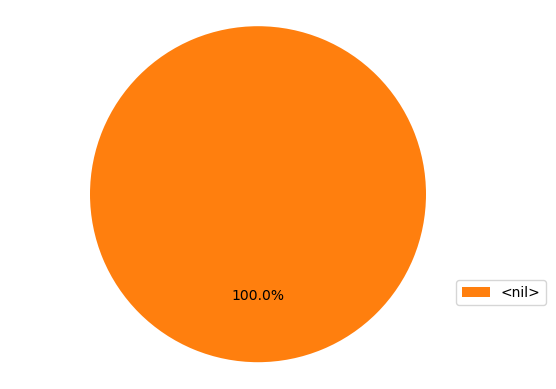

In [53]:
# Simulate the model with Condition 1 >
# Condition 1: the pre-defined initial state probabilities of 
res = model.run()
res.plot_piechart()

In [54]:
def tabulate_node_prob(model):
    """
    Extracts the ON/OFF probability of every node in a MaBoSS model
    and returns it as a pandas DataFrame.
    """
    node_prob = model.network.get_istate()
    df = (pd.DataFrame(node_prob).T
            .rename(columns={0: "OFF", 1: "ON"})
            .reset_index()
            .rename(columns={"index": "Node"}))
    return df
df = tabulate_node_prob(model)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df)

,Node,OFF,ON
0,TRADD,1,0
1,FADD,1,0
2,Complex_br_TNFR1TNF_complex,1,0
3,Complex_br_FADDTRADD_complex,1,0
4,RAIDD,1,0
5,TRAF2,1,0
6,RIP,1,0
7,Complex_br_TRADDRAIDD_br_TRAF2RIP_complex,1,0
8,I_kappa_B,1,0
9,NF_kappa_B,1,0


In [55]:
def count_initial_state_prob (model):
    """
    Count and print how many nodes share each distinct (OFF, ON) initial probability.
    """
    node_prob = model.network.get_istate()
    pattern_counts = {}
    for node, probs in node_prob.items():
        key = (probs[0], probs[1])
        pattern_counts[key] = pattern_counts.get(key,0) + 1
    for (off, on), count in sorted(pattern_counts.items(), key = lambda x:(-x[1], x[0])):
        print(f"The number of nodes with OFF/ON = ({off}, {on}) is {count}")
    return pattern_counts

count_initial_state_prob(model)

The number of nodes with OFF/ON = (1, 0) is 102


{(1, 0): 102}

In [56]:
# Simulate the model with Condition 2 >
# Condition 2: ALL nodes get 50% possibilty of OFF and 50% of ON. 
all_nodes_50_ON_model = model.copy()
df_before = tabulate_node_prob(all_nodes_50_ON_model)
count_before = count_initial_state_prob(all_nodes_50_ON_model)

for node in all_nodes:
    all_nodes_50_ON_model.network.set_istate(node, [0.5,0.5])
# Extract the node probability again, after applying the changes.
df_after = tabulate_node_prob(all_nodes_50_ON_model)
count_after = count_initial_state_prob(all_nodes_50_ON_model)

The number of nodes with OFF/ON = (1, 0) is 102
The number of nodes with OFF/ON = (0.5, 0.5) is 102


In [57]:
# Combine the _before and _after tables.
df_compare = df_before.merge(df_after, on="Node", suffixes=("_before", "_after"))
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_compare)

,Node,OFF_before,ON_before,OFF_after,ON_after
0,TRADD,1,0,0.5,0.5
1,FADD,1,0,0.5,0.5
2,Complex_br_TNFR1TNF_complex,1,0,0.5,0.5
3,Complex_br_FADDTRADD_complex,1,0,0.5,0.5
4,RAIDD,1,0,0.5,0.5
5,TRAF2,1,0,0.5,0.5
6,RIP,1,0,0.5,0.5
7,Complex_br_TRADDRAIDD_br_TRAF2RIP_complex,1,0,0.5,0.5
8,I_kappa_B,1,0,0.5,0.5
9,NF_kappa_B,1,0,0.5,0.5


In [58]:
# Textualise the changes.
print(f"Before change: {count_before}\nAfter change: {count_after}")

Before change: {(1, 0): 102}
After change: {(0.5, 0.5): 102}


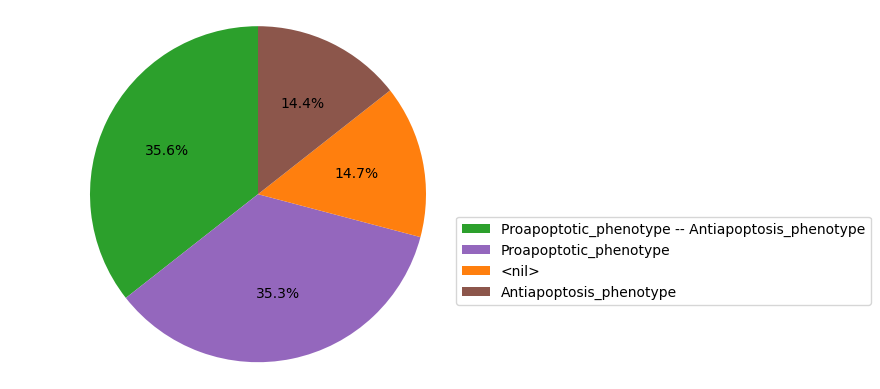

In [59]:
# Run the simulation and Return the pie chart.
res_all_nodes_50_OFF = all_nodes_50_ON_model.run()
res_all_nodes_50_OFF.plot_piechart()

# The pie chart shows that the model does not rule out that both phenotypes can be activated.

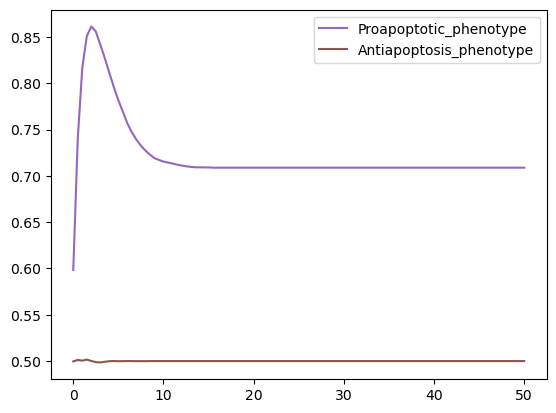

In [60]:
# Simulate - ALL nodes get 50% possibilty of ON (or OFF).
# This plot is node-level, showing how fast (x=time) each node becomes ON.
res_all_nodes_50_OFF.plot_node_trajectory(until=50)

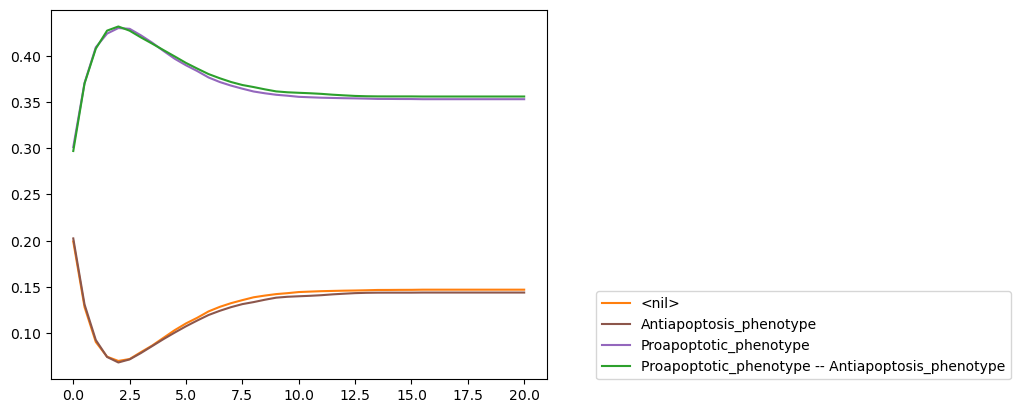

In [61]:
# Simulate - ALL nodes get 50% possibilty of ON (or OFF).
# This plot is model-level, showing the fractions of cells end up in different fates over time.
res_all_nodes_50_OFF.plot_trajectory(until=20)

# Interpretation: this simulation represents a population-level view of the model and how the fractions of cells occupying different phenotypic states change over logical time.
## 1. We found that 
### 1. "Proapoptotic_phenotype" overlaps with "Proapoptotic_phenotype -- Antiapoptotic_phenotype"
### 2. "<nil>" overlaps with "Antiapoptotic_phenotype": 
### 3. <nil> & Antiapoptosis_phenotype are the less dominant phenotypes (given the 50% ON/OFF)

In [62]:
from maboss.pipelines import simulate_single_mutants, filter_sensitivity
import matplotlib.pyplot as plt

The number of nodes with OFF/ON = (1, 0) is 102
The number of nodes with OFF/ON = (1, 0) is 59
The number of nodes with OFF/ON = (0, 1) is 43


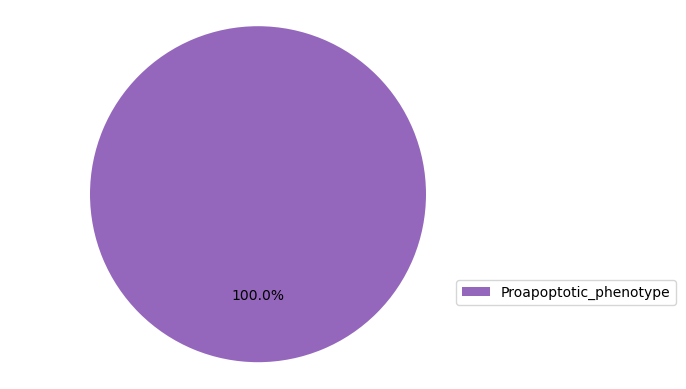

In [72]:
# Simulate the model with Condition 3 >
# Condition 3: all INPUT nodes are 100% ON. 
model_input_all_on = model.copy()
count_before = count_initial_state_prob(model_input_all_on)
for nodes in input_nodes:
    model_input_all_on.network.set_istate(nodes, [0,1])
count_after = count_initial_state_prob(model_input_all_on)

res_all_on = model_input_all_on.run()
res_all_on.plot_piechart()

The number of nodes with OFF/ON = (1, 0) is 102
The number of nodes with OFF/ON = (1, 0) is 94
The number of nodes with OFF/ON = (0, 1) is 8


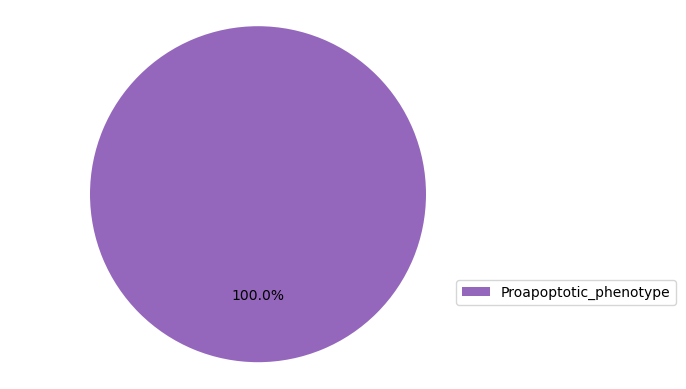

In [76]:
# Simulate the model with Condition 4 >
# Condition 4: all SetofEight INPUT nodes are 100% ON.
# The set of 8 input nodes were identified through Cell Collective interface.
set_of_eight_inputs = ["ASK1", "DAXX", "FAS_br_ligand", "FAS", "Complex_br_FoscJun_complex_c5_1", "FADD", "MKK7", "JNK"]

model_setofeightinputs_all_on = model.copy()
count_before = count_initial_state_prob(model_setofeightinputs_all_on)
for nodes in set_of_eight_inputs:
    model_setofeightinputs_all_on.network.set_istate(nodes, [0,1])
count_after = count_initial_state_prob(model_setofeightinputs_all_on)

res_setofeightinputs_on = model_setofeightinputs_all_on.run()
res_setofeightinputs_on.plot_piechart()

/opt/anaconda3/envs/sizek19/lib/python3.14/site-packages/maboss/results/baseresult.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(1,1)


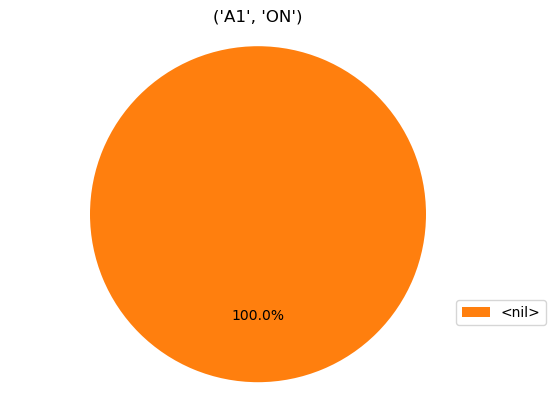

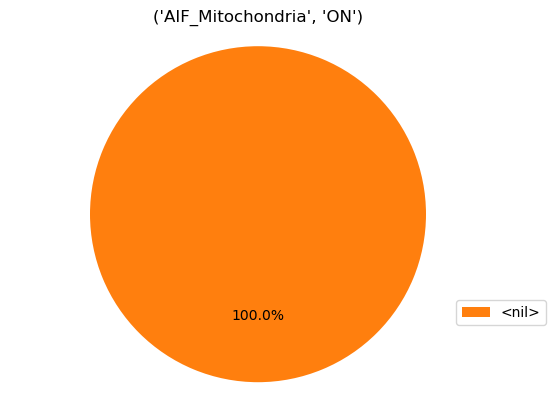

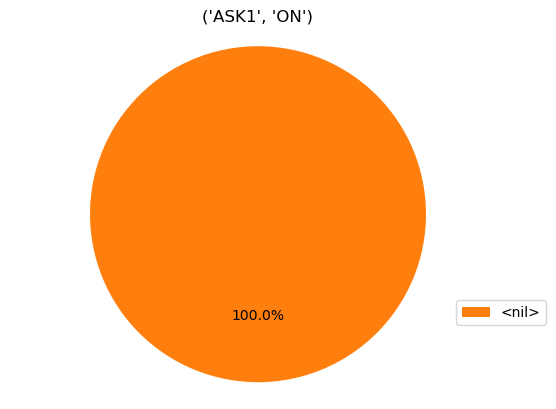

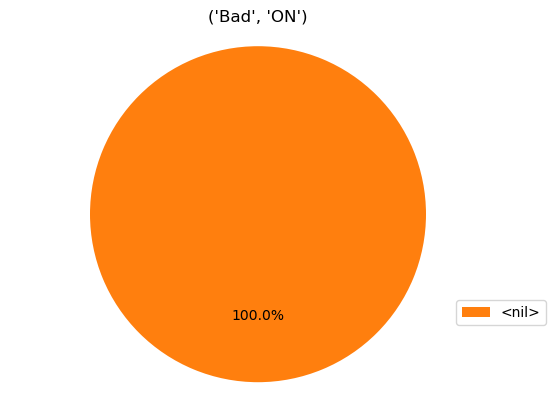

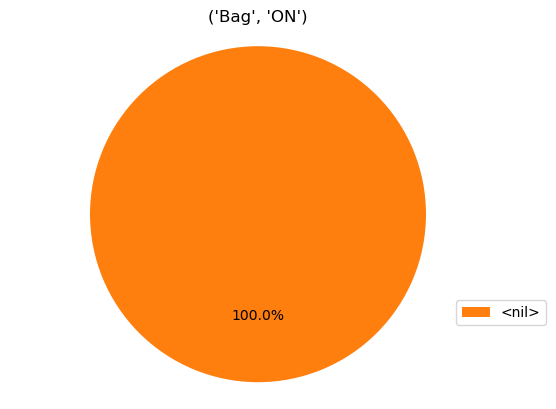

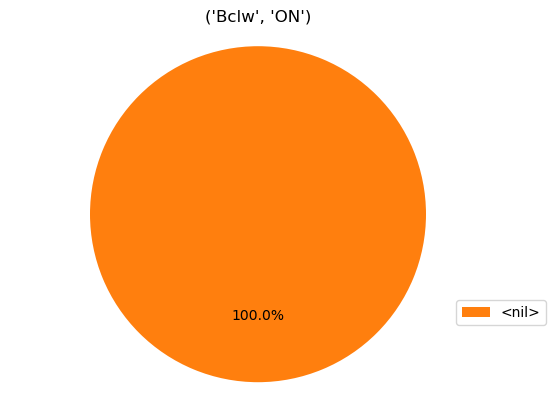

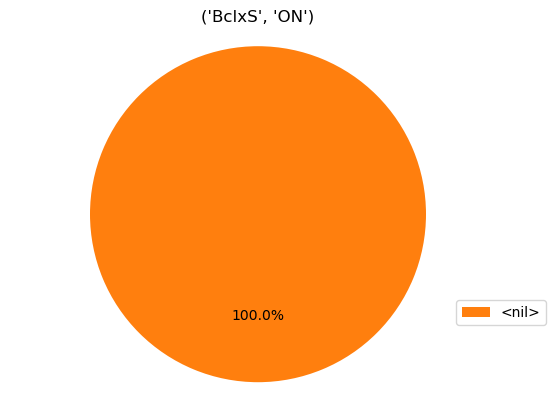

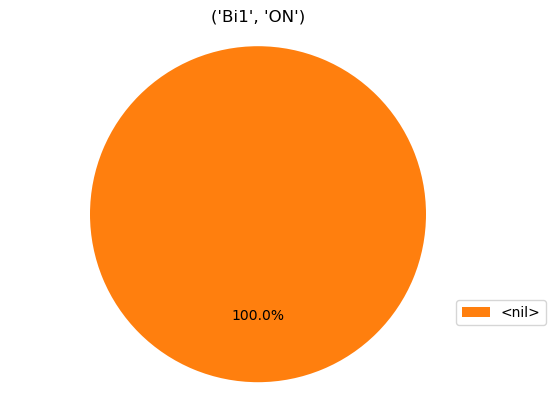

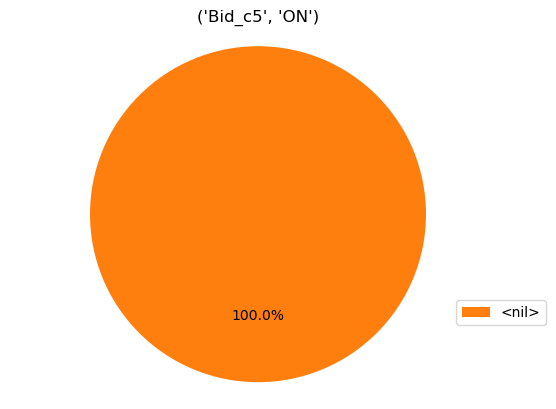

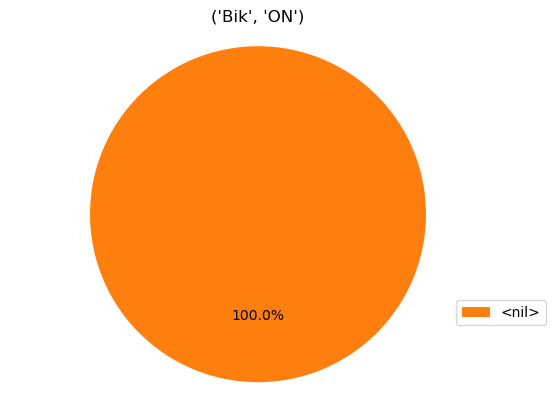

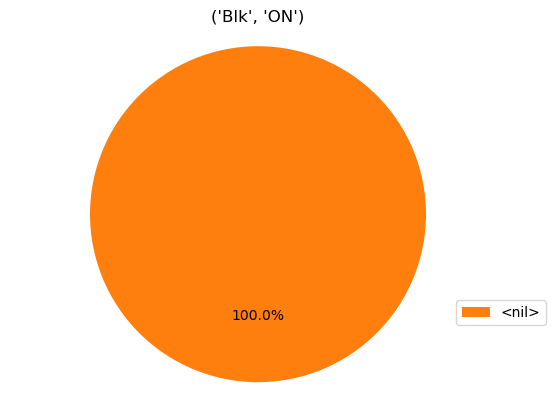

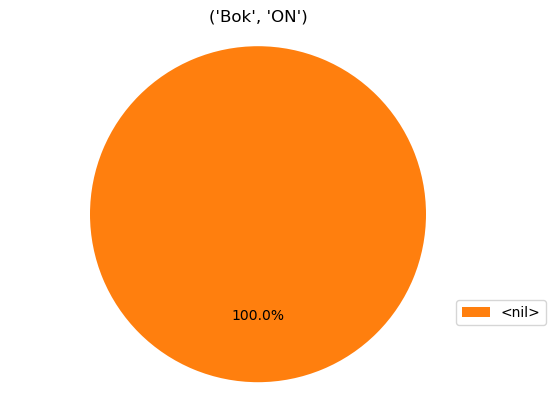

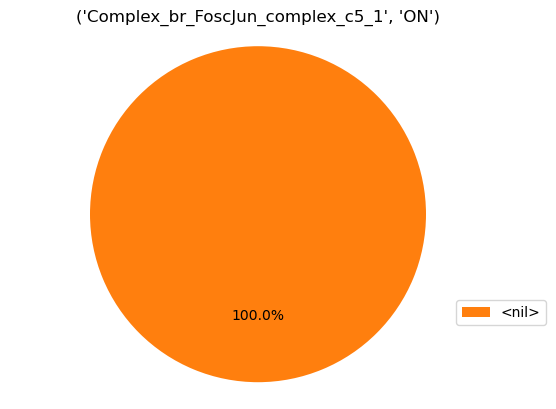

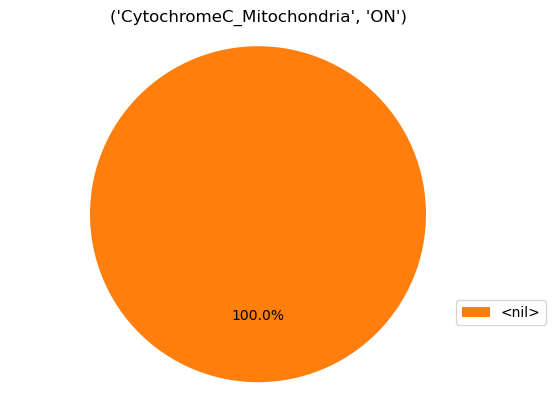

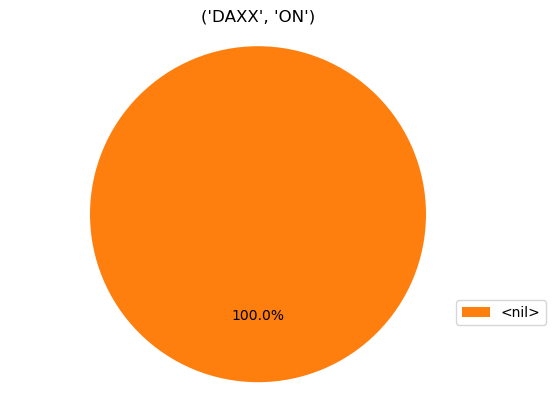

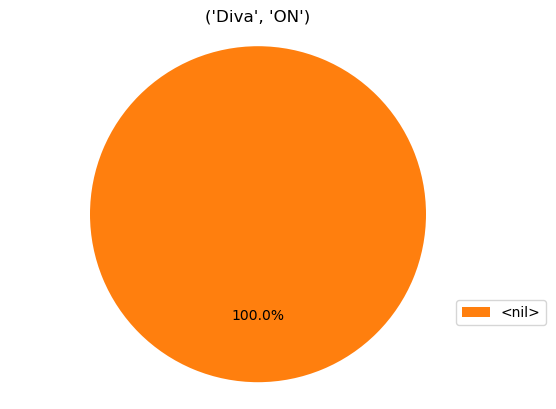

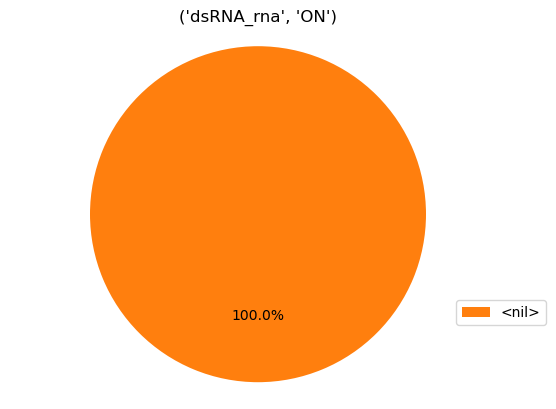

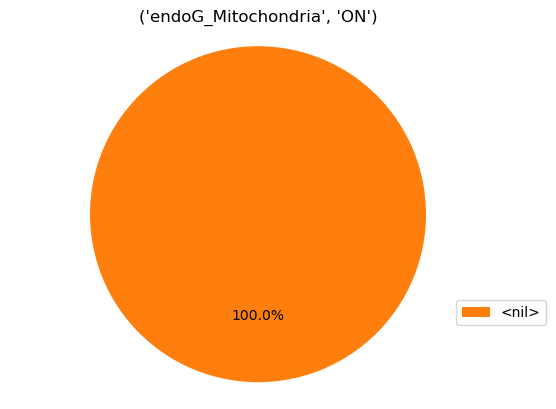

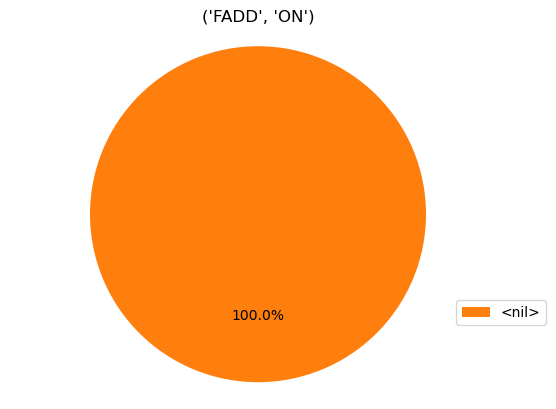

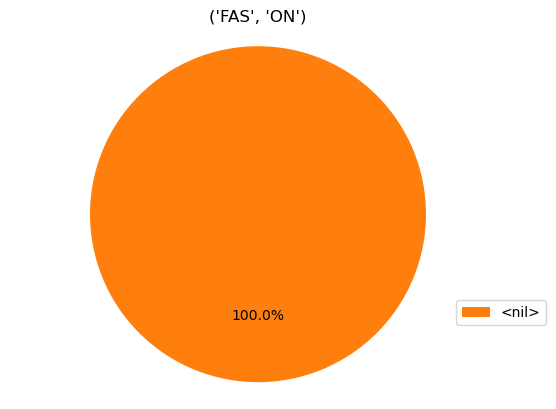

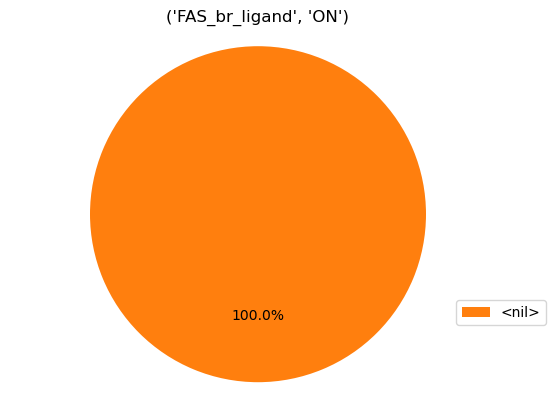

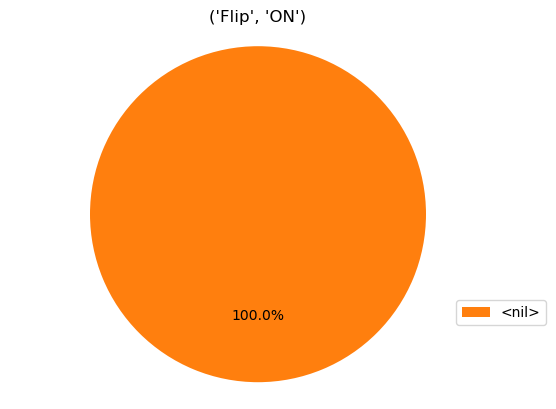

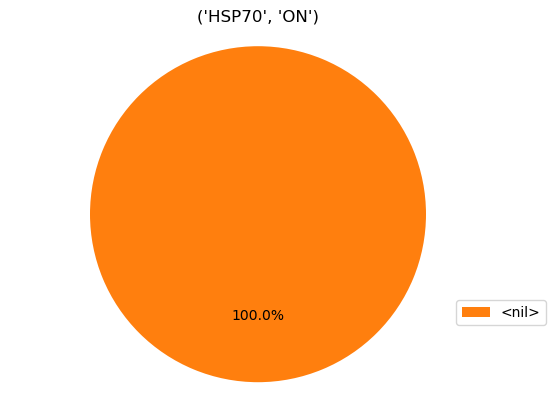

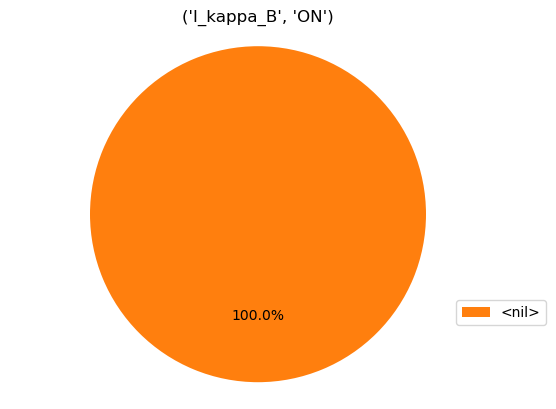

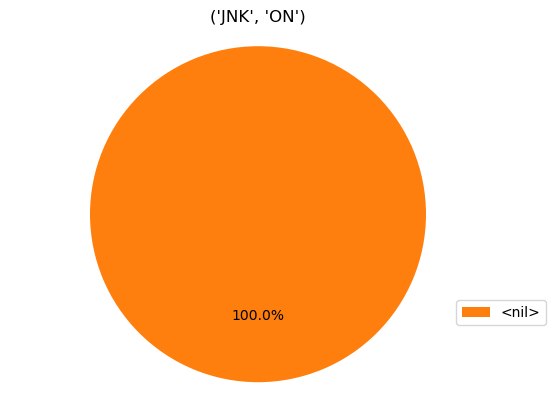

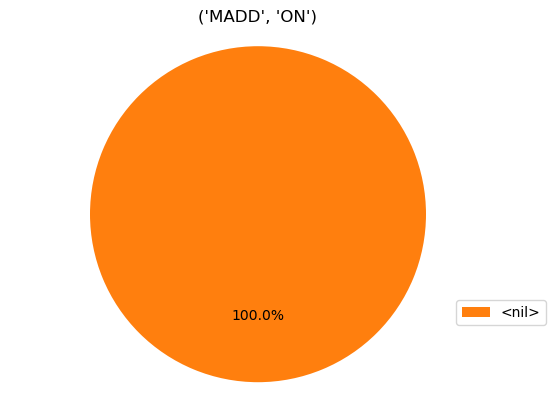

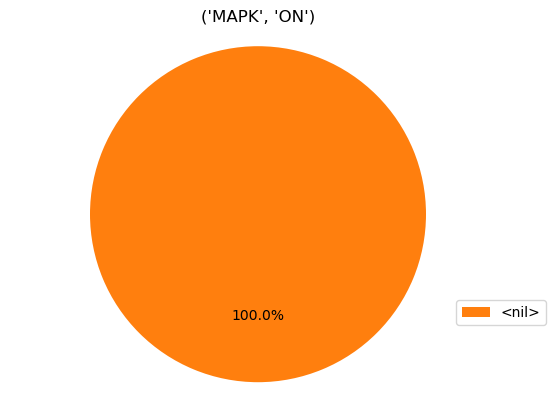

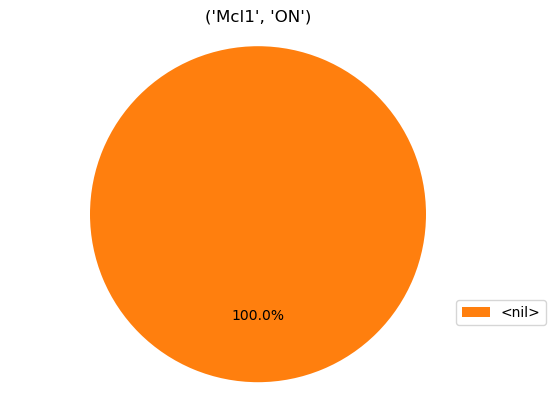

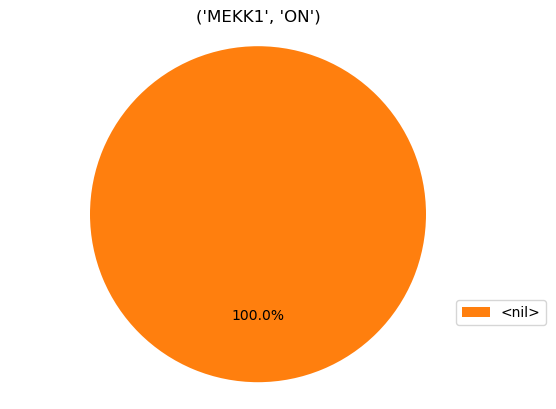

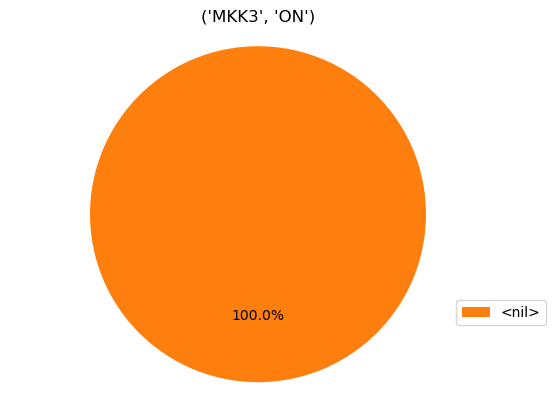

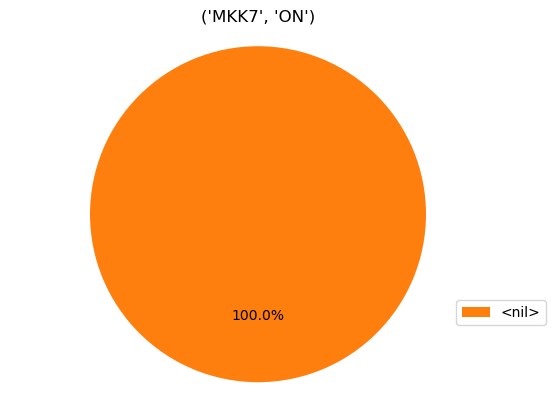

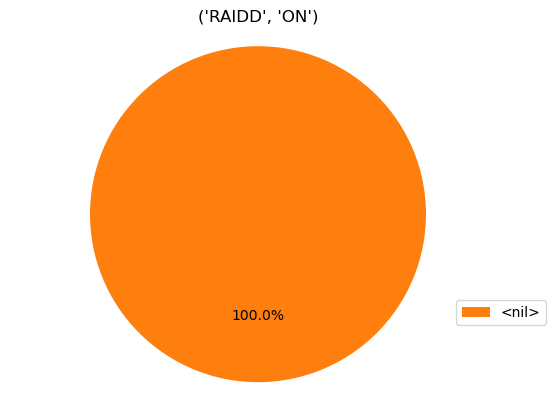

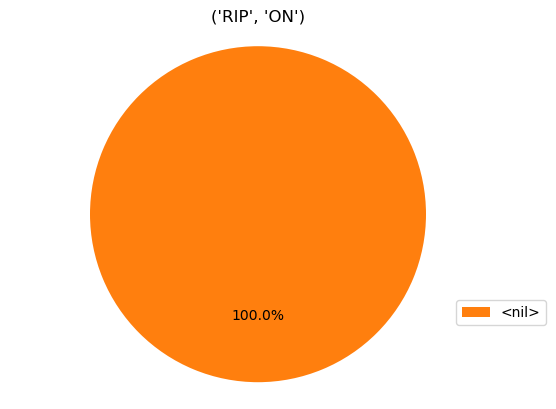

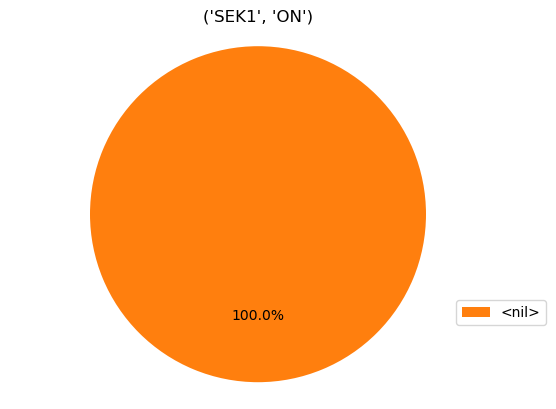

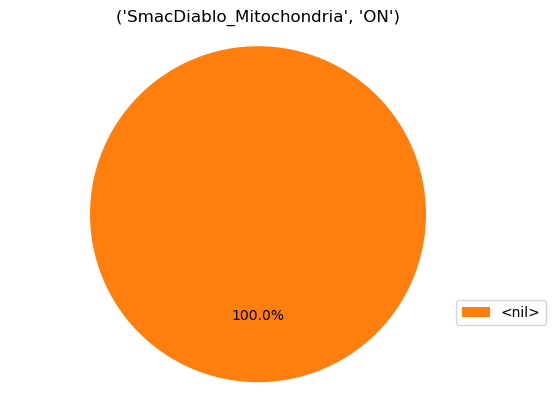

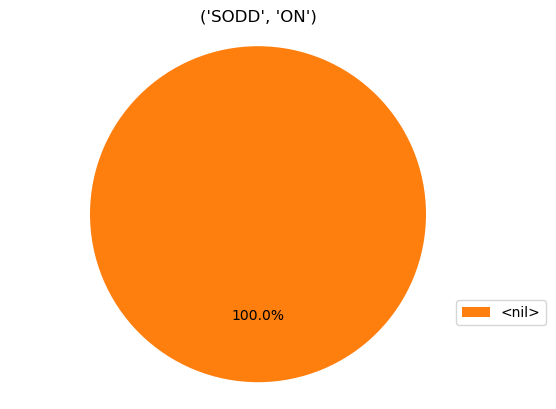

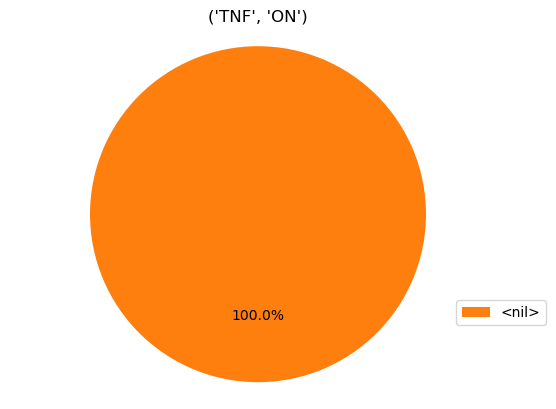

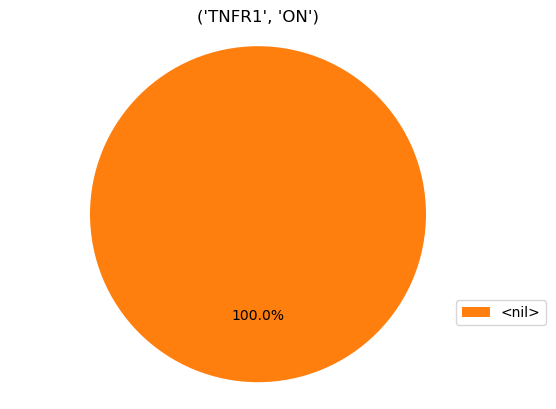

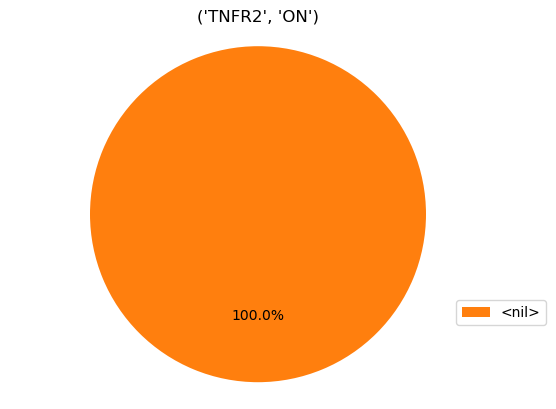

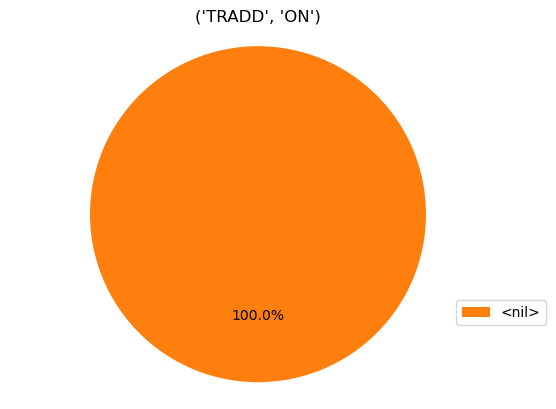

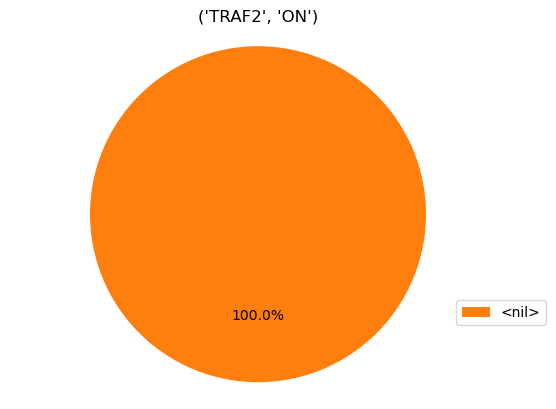

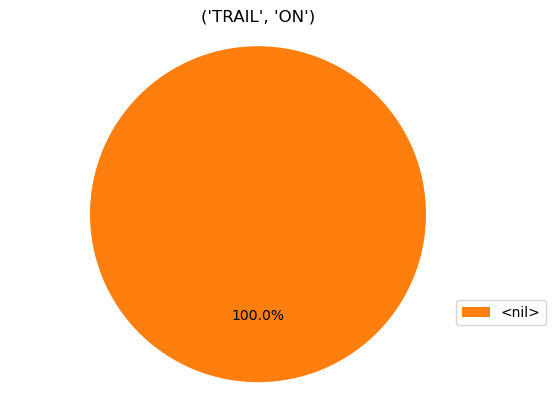

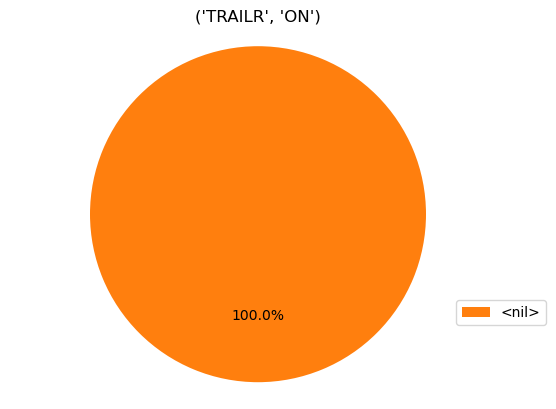

In [77]:
# Caution: the built-in sensitivity analysis may not be ideal for scanning Input nodes.
# the sensitivity analysis is instead for internal nodes.
# Note: in the answer template, the candidate_nodes are all internal nodes, not input nodes.

# Simulate through each input node one at a time (ON)
model_individual_ON = model.copy()
simulation_individual_ON = simulate_single_mutants(model_individual_ON, input_nodes, 'ON')
for simulation_individual_ON, result in simulation_individual_ON.items():
    result.plot_piechart()
    plt.title(simulation_individual_ON)

In [28]:
from maboss.pipelines import simulate_double_mutants

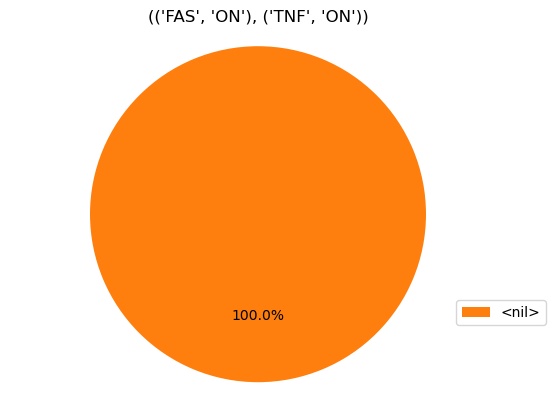

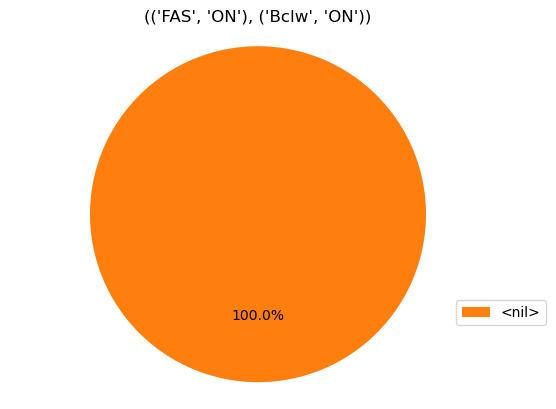

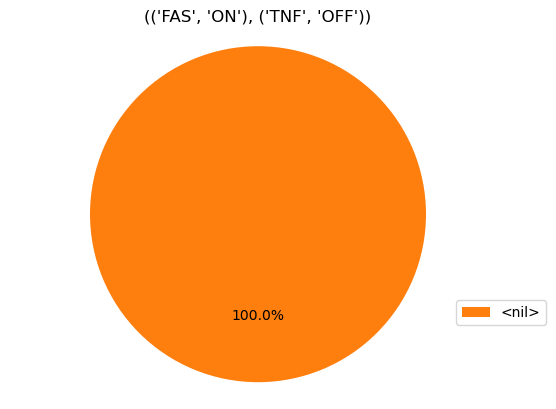

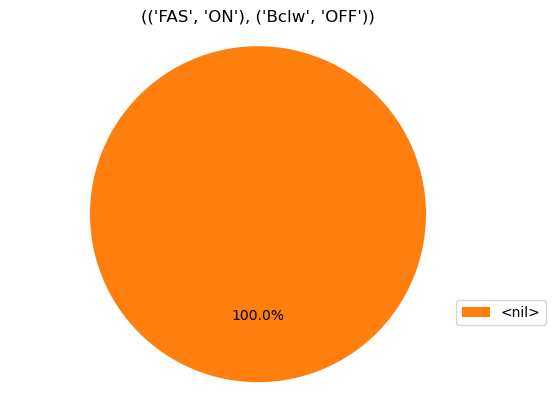

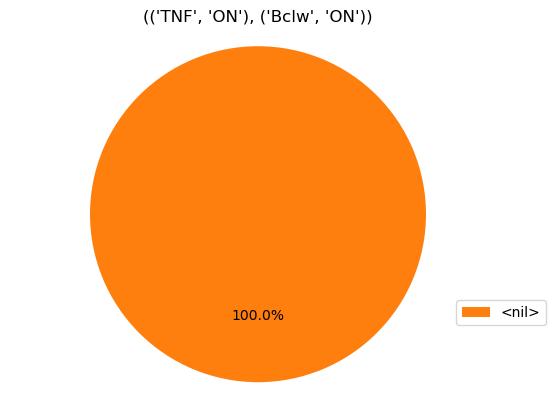

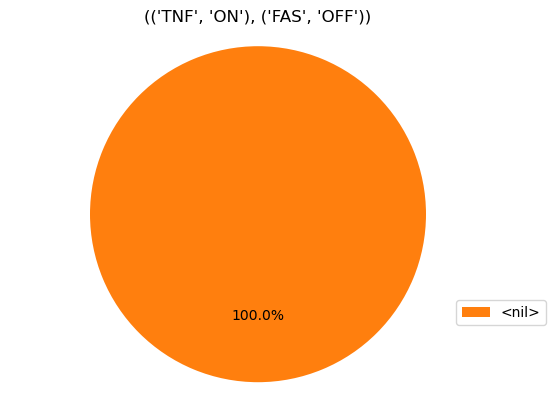

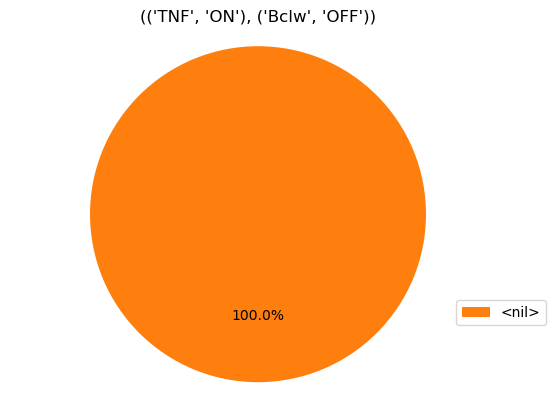

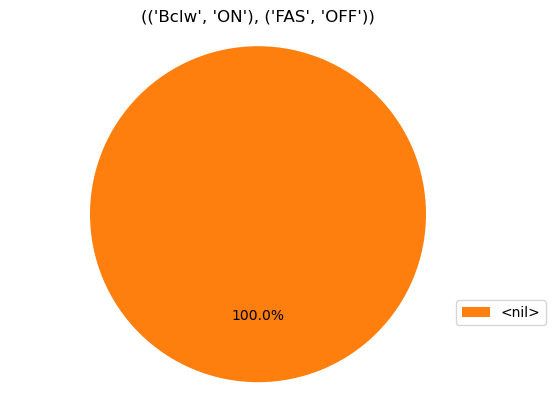

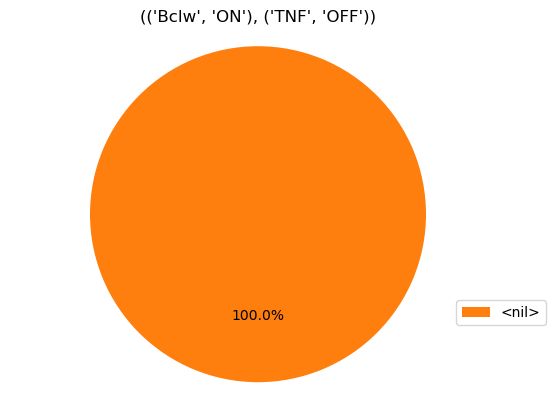

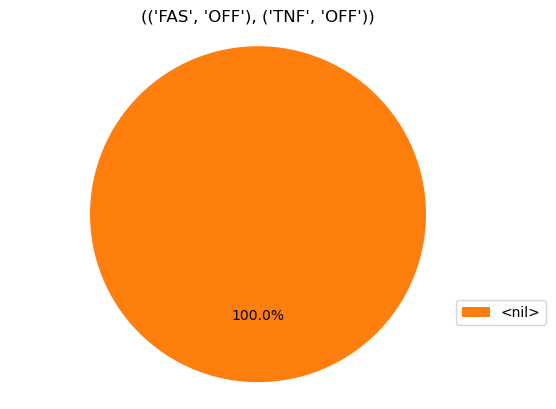

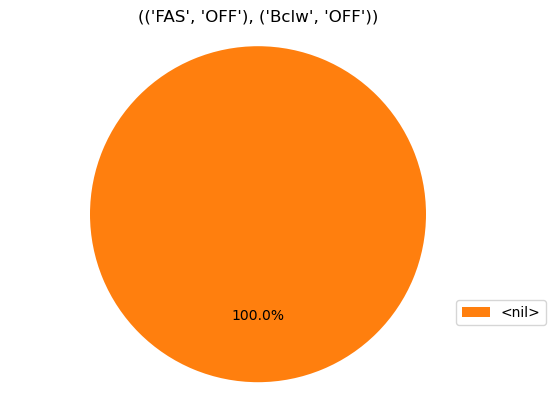

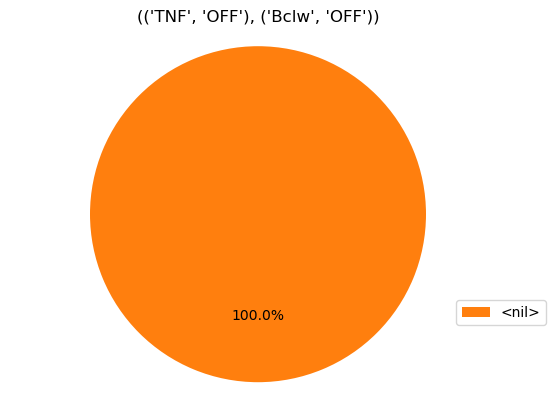

In [29]:
# Simulate through each input node TWO at a time
model_double_ONOFF = model.copy()
simulation_double_ONOFF = simulate_double_mutants(model_double_ONOFF, input_nodes, sign='BOTH', cmaboss=False)
for simulation_double_ONOFF, result in simulation_double_ONOFF.items():
    result.plot_piechart()
    plt.title(simulation_double_ONOFF)

In [ ]:
# Ignore below for now

In [ ]:
import math
import itertools
import pandas as pd

In [148]:
# Whether a SINGLE input activates apoptosis.
single_input_model = model.copy()
single_input_results = {}
# Iterature through all input nodes, One at a time.
for single_input_node in input_nodes:
    # we need to turn off other nodes (otherwise we get increasing ON nodes)
    for n in input_nodes: 
        single_input_model.network.set_istate(n, [1, 0])
    single_input_model.network.set_istate(single_input_node, [0, 1])
    res_single_input_model = single_input_model.run()
    df = res_single_input_model.get_states_probtraj()
    # Compute probibility of Apoptosis ON
    apoptosis_on = df.loc[:, df.columns.str.contains(f'Apoptosis=1')].sum().sum()
    single_input_results[single_input_node] = (1-apoptosis_on, apoptosis_on)

df = pd.DataFrame([
    {'Inputs': single_input_node, 'p_apoptosis': prob}
    for single_input_node, prob in single_input_results.items()
])
df

,Inputs,p_apoptosis
0,SARSM,"(1.0, 0.0)"
1,FASFASL_complex,"(1.0, 0.0)"
2,TNFATNFR1_complex,"(1.0, 0.0)"
3,APAF1,"(1.0, 0.0)"
4,TRADD,"(1.0, 0.0)"
5,Procasp9,"(1.0, 0.0)"
6,SARSE7a,"(1.0, 0.0)"
7,SARS3a,"(1.0, 0.0)"


In [150]:
double_input_model = model.copy()
double_input_results = {}
for double_input_nodes in itertools.combinations(input_nodes, 2):
    for n in input_nodes:
        double_input_model.network.set_istate(n, [1,0])
    for n in double_input_nodes:
        double_input_model.network.set_istate(n, [0,1])
    res_double_input_model = double_input_model.run()
    df = res_double_input_model.get_states_probtraj()

    apoptosis_on = df.loc[:, df.columns.str.contains('Apoptosis=1')].sum().sum()
    double_input_results[double_input_nodes] = (1-apoptosis_on, apoptosis_on)

df_double = pd.DataFrame(
    {
        'Inputs': ' + '.join(pair),
        'p_apoptosis': p_on,
    }
    for pair, (_, p_on) in double_input_results.items()
)

In [151]:
df_double

,Inputs,p_apoptosis
0,SARSM + FASFASL_complex,0.0
1,SARSM + TNFATNFR1_complex,0.0
2,SARSM + APAF1,0.0
3,SARSM + TRADD,0.0
4,SARSM + Procasp9,0.0
5,SARSM + SARSE7a,0.0
6,SARSM + SARS3a,0.0
7,FASFASL_complex + TNFATNFR1_complex,0.0
8,FASFASL_complex + APAF1,0.0
9,FASFASL_complex + TRADD,0.0


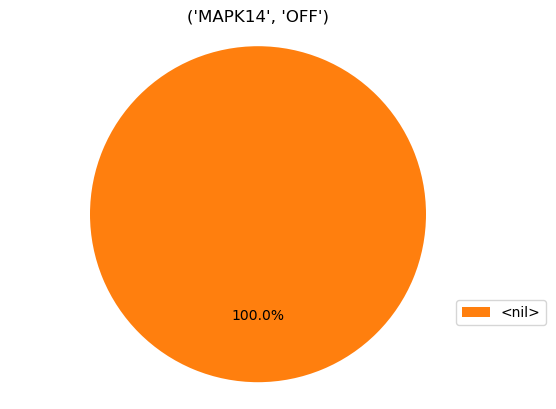

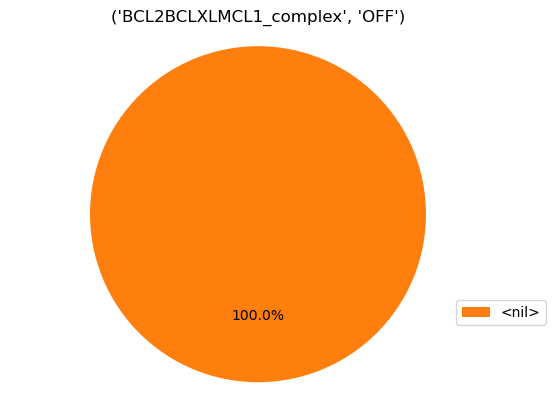

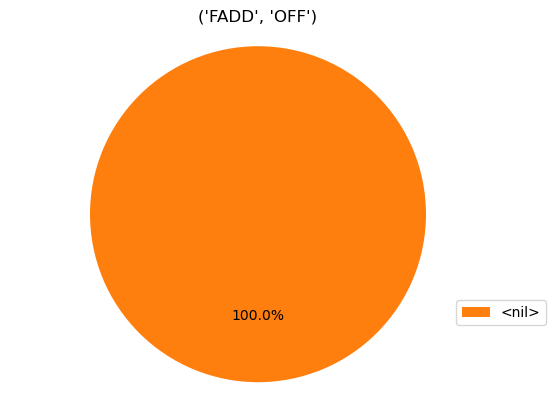

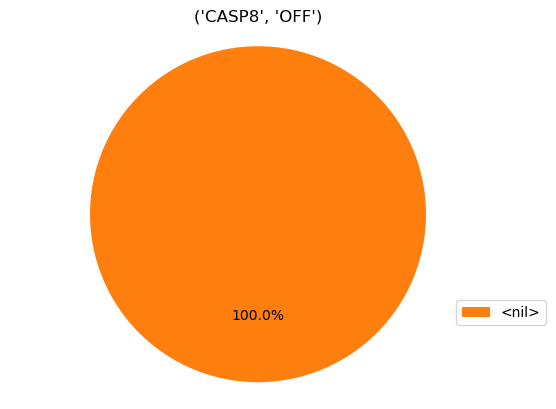

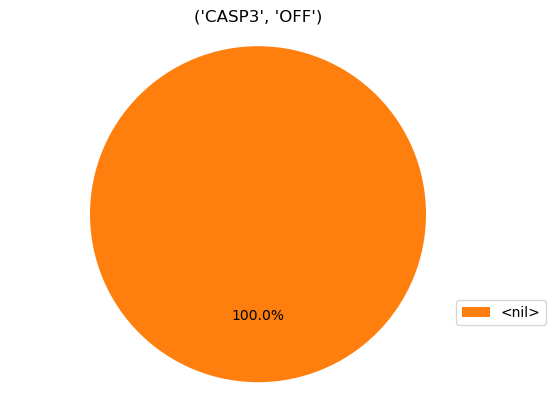

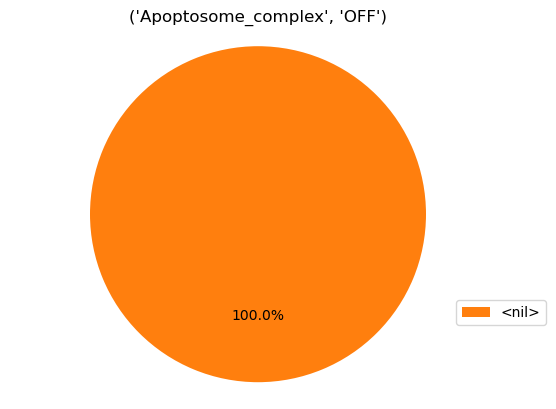

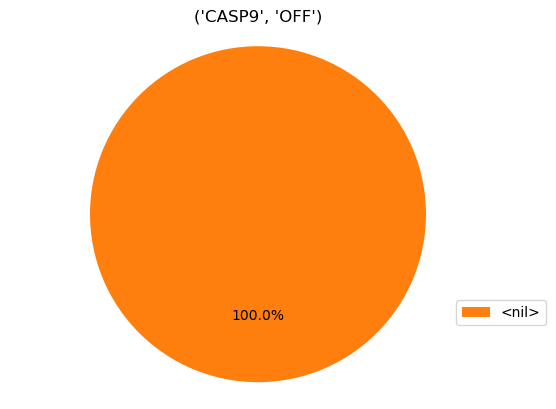

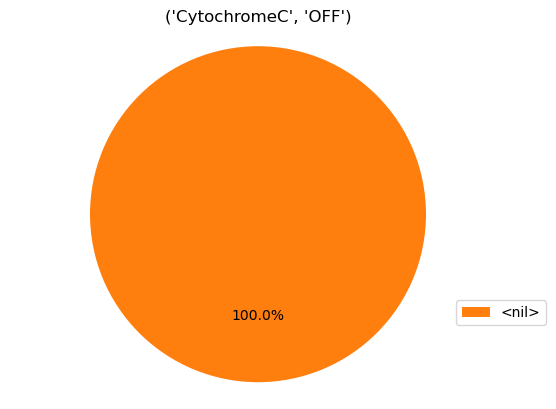

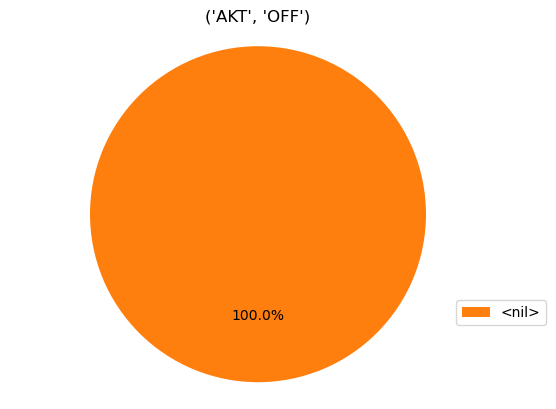

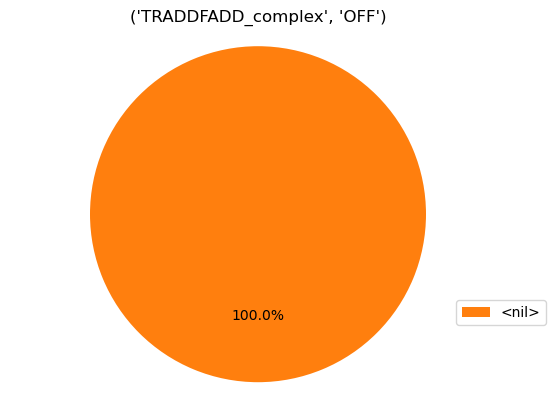

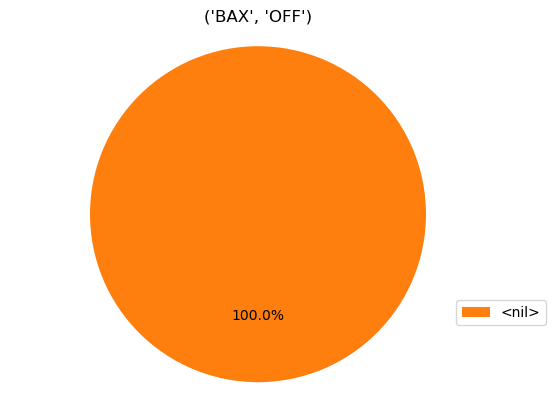

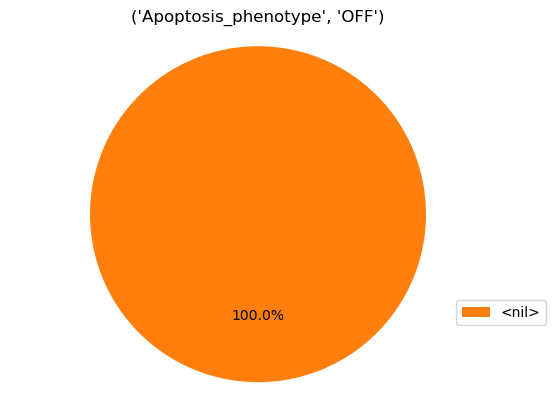

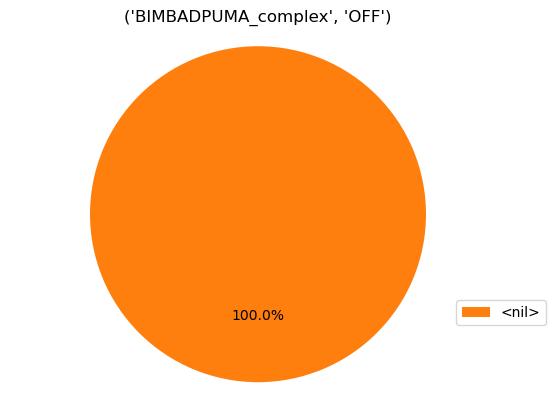

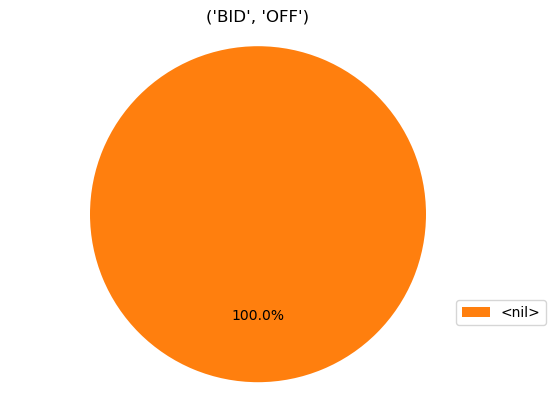

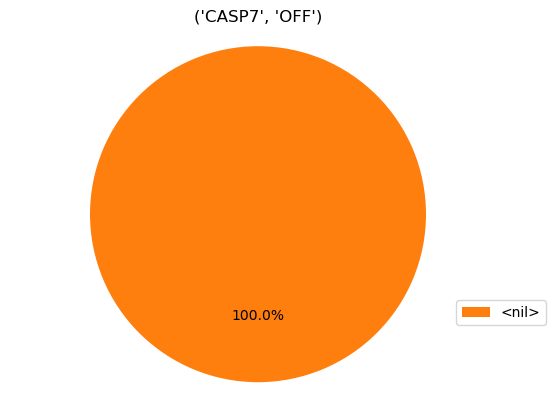

In [155]:
# Simulate through each INTERNAL node one at a time (ON)
single_internal_mutants_model = model.copy()
simulate_single_internal_mutants = simulate_single_mutants(single_internal_mutants_model, internal_nodes, 'OFF')
for simulate_single_internal_mutants, result in simulate_single_internal_mutants.items():
    result.plot_piechart()
    plt.title(simulate_single_internal_mutants)